In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from pso_tf import PSO

import numpy as np

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(777)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import matplotlib.pyplot as plt
from datetime import date

print(tf.__version__)
print(tf.config.list_physical_devices())

def get_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train, x_test = x_train / 255.0, x_test / 255.0
    x_train = x_train.reshape((60000, 28 ,28, 1))
    x_test = x_test.reshape((10000, 28 ,28, 1))

    print(f"x_train : {x_train[0].shape} | y_train : {y_train[0].shape}")
    print(f"x_test : {x_test[0].shape} | y_test : {y_test[0].shape}")
    return x_train, y_train, x_test, y_test

def make_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

    model.summary()

    return model

2023-05-21 03:38:18.127052: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
x_train, y_train, x_test, y_test = get_data()
model = make_model()

loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.SGD(lr=0.1, momentum=1, decay=1e-05, nesterov=True)

pso_m = PSO(model=model, loss_method=loss, optimizer=optimizer, n_particles=2)
best_weights, score = pso_m.optimize(x_train, y_train, x_test, y_test, maxiter=10)

model.set_weights(best_weights)

score = model.evaluate(x_test, y_test, verbose=2)
print(f"Test loss: {score[0]} / Test accuracy: {score[1]}")

day = date.today().strftime("%Y-%m-%d")

model.save(f'./model/{day}_mnist.h5')


x_train : (28, 28, 1) | y_train : ()
x_test : (28, 28, 1) | y_test : ()
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 3, 3, 64)          0         
                                                  

/home/pieroot/miniconda3/envs/pso/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
Iteration 0 / 10: 100%|##########| 2/2 [00:48<00:00, 24.43s/it]


loss : 0.021180160343647003 | acc : 0.9930999875068665


Iteration 1 / 10: 100%|##########| 2/2 [00:46<00:00, 23.46s/it]


loss : 0.029995786026120186 | acc : 0.9927999973297119


Iteration 2 / 10: 100%|##########| 2/2 [00:47<00:00, 23.57s/it]


loss : 0.13020965456962585 | acc : 0.9929999709129333


Iteration 3 / 10: 100%|##########| 2/2 [00:47<00:00, 23.62s/it]


loss : 0.032199352979660034 | acc : 0.9918000102043152


Iteration 4 / 10: 100%|##########| 2/2 [00:47<00:00, 23.66s/it]


loss : 0.025606701150536537 | acc : 0.9925000071525574


Iteration 5 / 10: 100%|##########| 2/2 [00:47<00:00, 23.64s/it]


loss : 0.04198306426405907 | acc : 0.9921000003814697


Iteration 6 / 10: 100%|##########| 2/2 [00:47<00:00, 23.69s/it]


loss : 0.048351287841796875 | acc : 0.9919999837875366


Iteration 7 / 10: 100%|##########| 2/2 [00:47<00:00, 23.73s/it]


loss : 0.0416271910071373 | acc : 0.9890999794006348


Iteration 8 / 10: 100%|##########| 2/2 [00:47<00:00, 23.70s/it]


loss : 0.18129077553749084 | acc : 0.9502000212669373


Iteration 9 / 10: 100%|##########| 2/2 [00:47<00:00, 23.69s/it]


loss : 0.8072962760925293 | acc : 0.7225000262260437
313/313 - 0s - loss: 0.0212 - accuracy: 0.9931 - 290ms/epoch - 926us/step
Test loss: 0.021180160343647003 / Test accuracy: 0.9930999875068665


313/313 [==============================] - 0s 685us/step
틀린 것 갯수 > 69


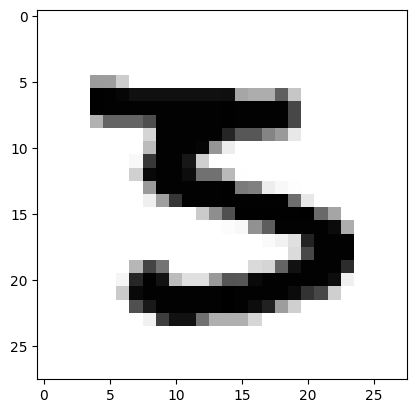

In [3]:
# print(f"정답 > {y_test}")
predicted_result = model.predict(x_test)
predicted_labels = np.argmax(predicted_result, axis=1)
not_correct = []
for i in range(len(y_test)):
    if predicted_labels[i] != y_test[i]:
        not_correct.append(i)
        # print(f"추론 > {predicted_labels[i]} | 정답 > {y_test[i]}")
        
print(f"틀린 것 갯수 > {len(not_correct)}")
for i in range(3):
    plt.imshow(x_test[not_correct[i]].reshape(28,28), cmap='Greys')
plt.show()